In [1]:
import dwave_sapi2
from dwave_sapi2.local import local_connection
from dwave_sapi2.remote import RemoteConnection
from dwave_sapi2.core import async_solve_ising, await_completion, solve_ising
from dwave_sapi2.util import get_hardware_adjacency, qubo_to_ising
from dwave_sapi2.embedding import find_embedding, embed_problem, unembed_answer
import time
import dwave_sapi2.remote
import sys
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sio
from scipy.stats import ortho_group
from sklearn.svm import SVC 
import math 
import random
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.linear_model import orthogonal_mp

In [ ]:
!conda install -y -c anaconda seaborn=0.9.0


In [2]:
conn = dwave_sapi2.remote.RemoteConnection('https://cloud.dwavesys.com/sapi','lanl-871046202c27322e8450da36b7b35653c94c1115	')
print conn.solver_names()

['DW_2000Q_2_1', 'DW_2000Q_5', 'DW_2000Q_VFYC_2_1', 'c4-sw_optimize', 'DW_2000Q_VFYC_5', 'c4-sw_sample']


In [4]:
cd Desktop/LANL/AFRL-DISC Data/Blackbox brief for LANL

C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL


In [5]:
sPCA= pd.read_csv('sPCA_32.csv', sep=',', encoding = 'utf8')
data = sPCA.values
#data = data.reshape(len(data)*4,8)

In [4]:
#binary spca components
mat = sio.loadmat('data_binned.mat')
data = np.asarray(mat['data_binned'])
data = data.astype(np.float32)/255

In [6]:
#normalize data
for i in range(len(data)):
    if LA.norm(data[i])!=0:
        data[i]=data[i]/LA.norm(data[i])


In [73]:
mat =  sio.loadmat('Phi_New_Binned.mat')
Phi_New_Binned= mat['Phi_New_Binned']
Phi_New_Binned = Phi_New_Binned.astype(np.float32)/255

for i in range(Neurons):
    if LA.norm(Phi_New_Binned[:,i])!=0:
        Phi_New_Binned[:,i]= Phi_New_Binned[:,i]/(LA.norm(Phi_New_Binned[:,i]))
#

In [7]:

mat = sio.loadmat('fMnist_ytrainlabels.mat')
y_train = np.squeeze(np.asarray(mat['y_train'].T))
mat = sio.loadmat('fMnist_ytestlabels.mat')
y_test = np.squeeze(np.asarray(mat['y_test'].T))

In [8]:
def sparse_loss(I,Phi,sparse_representation_coefficients,lam):
    Energy = .5*(LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2) +lam*np.count_nonzero(sparse_representation_coefficients)
    return Energy

def reconstruction_loss(I,Phi,sparse_representation_coefficients):
    Loss = LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2
    return Loss

In [9]:
#Creating Random Phi Matrix
Neurons = 63
RandomTrainingSample_Index = random.sample(range(len(data)),Neurons)
Rand_Features = data[RandomTrainingSample_Index,:]


In [15]:
#Pull Random images for SGD Training
Num_Ran_Sam =10000
RandomTrainingSample_Index = random.sample(range(len(data)),Num_Ran_Sam)
Data_Patches = data[RandomTrainingSample_Index,:]

In [10]:
#Gett 6 features from each class and 4 Random
Selected_Features = []
for i in range(10):
    index = np.where(y_train==i)
    for i in range(6):
        Selected_Features.append(index[0][i])

max_element = max(Selected_Features)
for i in range(1,4):
    print(max_element)
    Selected_Features.append(max_element+i)
Selected_Features = np.asarray(Selected_Features)

105
105
105


In [11]:
len(Selected_Features)

63

In [12]:
#Normalize Phi
Phi = data[Selected_Features,:].T
#Phi = np.asmatrix(Phi)

for i in range(Neurons):
    if LA.norm(Phi[:,i])!=0:
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))
        Phi[:,i]= Phi[:,i]/LA.norm(Phi[:,i])
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))


In [11]:
Phi.shape

(32L, 62L)

In [16]:
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
lam = .4
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
h_vector = np.add(-np.dot(Phi.T,Data_Patches[0,:].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
h_vector = np.squeeze(np.asarray(h_vector))
#Replace Diagonal of Q with corresponding h values    
for i in range(0,len(Q)):
    Q[i,i]=h_vector[i]

# #trim wieghts/coupling strength   
for i in range(0,len(Q)):
    for j in range(i,len(Q)):
        if Q[i,j] < .1*Q.max():
            Q[i,j] = 0
#Create Dictionary of Upper Triangle part of Q with Diagonal Elements
QDictionary ={}
for i in range(0,len(Q)):
    for j in range(i,len(Q)):
            QDictionary[(i,j)] = Q[i,j]
            #print(i,j,Q[i,j])



In [12]:
Q.max()

NameError: name 'Q' is not defined

In [17]:
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
lam = .4
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
h_vector = np.add(-np.dot(Phi.T,Data_Patches[0,:].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
h_vector = np.squeeze(np.asarray(h_vector))
#Replace Diagonal of Q with corresponding h values    
for i in range(0,len(Q)):
    Q[i,i]=h_vector[i]

#Create Dictionary of Upper Triangle part of Q with Diagonal Elements
QDictionary ={}
for i in range(0,len(Q)):
    for j in range(i,len(Q)):
            QDictionary[(i,j)] = Q[i,j]

In [18]:
#Finding lowest Energy Embedding    
solver = conn.get_solver('DW_2000Q_VFYC_5') 
A = get_hardware_adjacency(solver)
Embedding_Trials = 2
Unembedded_Solutions=[]
Embeddings =[]
EmbeddingTime=[]
J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]

for i in range(Embedding_Trials):
    
        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        print(np.asarray(h_).shape)
        print(np.asarray(J_).shape)


        # find and print embeddings for problem graph
        t = time.time()

        embeddings = find_embedding(J_, A, verbose=1)
        elapsed = time.time() - t
        EmbeddingTime.append(elapsed)
        print "elapsed time:", elapsed
        #print "embeddings are: ", embeddings
        Embeddings.append(embeddings)

        # embed the problem into solver graph
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A) #update to have multiple solutions and save embeddings
#         print "embedded problem result:\nj0: ", j0
#         print "jc: ", jc
        J0.append(j0)
        JC.append(jc)

        # find unembedded results for chain strengths -0.5, -1.0, -2.0

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem

            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
            Answers.append(answer['energies'])

                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
            #Solutions.append(result['energies']) DOESNT HAVE energies AS AN OUTPUT

#             print(result)
#             print "result for chain strength = ", chain_strength
#             for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
#                 print "solution", i
#                 #save solution coefficients
#                 for j, emb in enumerate(embeddings):
#                     Coefficients_sol.append(sol[j])
#                     print "var %d: %d (" % (j, sol[j]),
#                     for k in emb:
#                         Coefficients_embsol.append(embsol[k])
#                         print "%d:%d" % (k, embsol[k]),
#                     print ")"
            #print "Solutions", Solutions
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            for i in range(0,len(x)):
                if x[i] == -1:
                     x[i] = 0
            New_Solutions.append(x)
        Unembedded_Solutions.append(New_Solutions)
        if __name__ == "__main__":
            if len(sys.argv) == 1:
                embedding_example()
            else:
                print "Usage: "
                #print "%s: Find embedding for k_6 structured graph, embed problem, solve problem, unembed answer" % sys.argv[0]

(63L,)
()
component 0, try 0:
max overfill = 2, num max overfills = 22
max overfill = 1, num max overfills = 1548
max overfill = 1, num max overfills = 1548
Embedding found. Minimizing chains...
max chain size = 32, num max chains = 1, qubits used = 1548
max chain size = 32, num max chains = 1, qubits used = 1548
max chain size = 32, num max chains = 1, qubits used = 1548
max chain size = 32, num max chains = 1, qubits used = 1548
elapsed time: 26.8570001125
Usage: 
(63L,)
()
component 0, try 0:
max overfill = 2, num max overfills = 32
max overfill = 1, num max overfills = 1511
max overfill = 1, num max overfills = 1511
Embedding found. Minimizing chains...
max chain size = 32, num max chains = 1, qubits used = 1511
max chain size = 31, num max chains = 9, qubits used = 1565
max chain size = 31, num max chains = 9, qubits used = 1565
max chain size = 31, num max chains = 9, qubits used = 1565
elapsed time: 31.2330000401
Usage: 


In [19]:
All_Energies = []
for i in range(len(Unembedded_Solutions)):
    Energy_Chain = []
    for j in range(len(Chains)):
        Energy_Chain.append(sparse_loss(Data_Patches[0],Phi,Unembedded_Solutions[i][j],lam))
    index_min = np.argmin(np.asarray(Energy_Chain))
    All_Energies.append(Energy_Chain[index_min])

In [20]:
index_min = np.argmin(np.asarray(All_Energies))
embeddings = Embeddings[index_min]

In [23]:
index_min_recon = np.argmin(np.asarray(lam_Reconstruction_Loss))
lam = lam_values[index_min_recon]

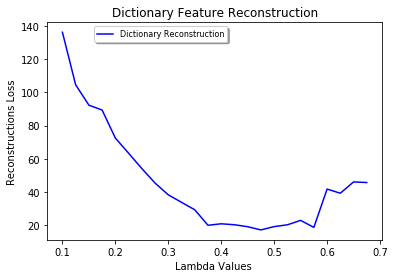

In [26]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(lam_values,lam_Reconstruction_Loss, 'k',color='blue',label='Dictionary Reconstruction')
#ax.plot(a, c, 'k', color='red',label='Regression')
#ax.plot(a, loss, 'k',color='green', label='loss')
#ax.axvline(x=19,linestyle='--', label ='Dropped Learning Rate')
# ax.axvline(x=220,linestyle='--', color='red',label ='Increase Learning Rate')
# ax.axvline(x=240,linestyle='--')
legend = ax.legend(loc='best', bbox_to_anchor=(0.55,1), shadow=True, fontsize='x-large',prop={'size': 8})
plt.xlabel('Lambda Values '),
plt.ylabel('Reconstructions Loss');
plt.title('Dictionary Feature Reconstruction')
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('C0')

plt.show()

In [25]:
lam_Reconstruction_Loss

[136.0795485354735,
 104.48006387314312,
 92.25792020688878,
 89.3026280505199,
 72.49094816146383,
 63.372510126671834,
 54.148334464009515,
 45.42188550946912,
 38.34562017099453,
 33.84911178303981,
 29.365528504603546,
 20.043176788361738,
 20.93905392194781,
 20.35798967705008,
 19.18858240796452,
 17.256243541599236,
 19.233238310497473,
 20.334741475016365,
 22.981213222983428,
 18.77627538654821,
 41.798049206440524,
 39.31032999821707,
 46.09283518675824,
 45.741261927071264]

In [21]:
#Beta Tuning
Unembedded_Solutions_Training= []
t1 = time.time()
New_Solutions = []
Temp_Data_Patches=[]
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))


J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
image_number = 0

#lam = .1
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0


solver = conn.get_solver('DW_2000Q_VFYC_5') 
A = get_hardware_adjacency(solver)

#Can be used to get entire sparse rep of desired data set. 
#Only looking at 10 to get idea of learning
number_of_images = 10
Indexing = random.sample(range(len(data)), number_of_images)
beta_vec = [ 1, 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]
beta_vec = [4,5,6,7,8]
Reconstruction_Error_All=[]
for beta in beta_vec:

    
    Reconstruction_Error_Beta =[]
    for image in Indexing:
        print(image,beta)
        temp = beta*data[image]
        h_vector = np.add(-np.dot(Phi.T,temp.T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]

        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

    #         embeddings = find_embedding(J_, A, verbose=1)
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)

        Solutions =[]
        Answers=[]

        Temp_Data_Patches.append(data[image].T)

            # solve embedded problem

        Solutions =[]
        Answers=[]
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=1000)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])



                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
 
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            x = (x+1)/2

            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        Reconstruction_Error_image=[]
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
            Energy = sparse_loss(temp,Phi,New_Solutions[k],lam)
#                 if LA.norm(New_Solutions[k])!=0:
#                     Error = reconstruction_loss(temp,Phi,New_Solutions[k]/LA.norm(New_Solutions[k]))
#                 else:
            Error = reconstruction_loss((1/float(beta))*temp,Phi,New_Solutions[k]*(1/float(beta)))
#                 normed_temp = temp/LA.norm(temp)
#                 Recon = np.dot(Phi,New_Solutions[k])
#                 if LA.norm(Recon)!=0:
#                     Recon = Recon/LA.norm(Recon)
                
#                 Error = LA.norm(normed_temp-Recon)
            Reconstruction_Error_image.append(Error)
            All_Energies.append(Energy)
        index_min = np.argmin(np.asarray(All_Energies))
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        im = np.argmin(np.asarray(Reconstruction_Error_image))
        Reconstruction_Error_Beta.append(Reconstruction_Error_image[index_min])
        if image_number%10==0:
            print('Image Found', image_number)
        #if image_number%10==0:
        print(New_Solutions[index_min])
        print(Reconstruction_Error_image[index_min])
        image_number+= 1
    Reconstruction_Error_All.append(Reconstruction_Error_Beta)



Sparse_Rep_Untrained  = np.asarray(Unembedded_Solutions_Training)


(55391, 4)
('Image Found', 0)
[0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.17416109164606766
(16424, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
0.49053857637523895
(43225, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
0.4163456042890281
(37571, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3304065575633969
(56431, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.35266110621965446
(49242, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
0.4651744719049171
(5971, 4)
[1 0 0 1 1 1 0

In [22]:
Sparse_Rep_Untrained.shape

(50L, 63L)

In [23]:
Reconstruction_Error_All = np.asarray(Reconstruction_Error_All)

Beta_Sums = []
for j in range(len(Reconstruction_Error_All)):
    Beta_Sums.append(sum(Reconstruction_Error_All[j]))
index_min_beta = np.argmin(np.asarray(Beta_Sums))   
beta = beta_vec[index_min_beta]
Beta_Sums = np.asarray(Beta_Sums)/len(Indexing)

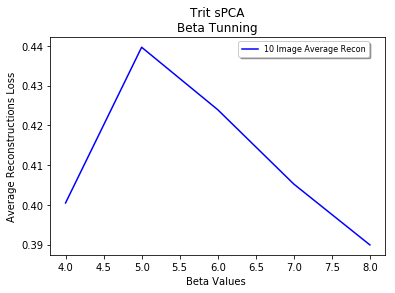

In [19]:

fig, ax = plt.subplots()
ax.plot(beta_vec,np.asarray(Beta_Sums), 'k',color='blue',label='10 Image Average Recon')
legend = ax.legend(loc='best', bbox_to_anchor=(0.55,1), shadow=True, fontsize='x-large',prop={'size': 8})
plt.xlabel('Beta Values '),
plt.ylabel('Average Reconstructions Loss');
plt.title('Trit sPCA\nBeta Tunning')


plt.show()

In [22]:
Sparse_Rep_Untrained.shape
Phi.shape

(32L, 64L)

In [20]:
Reconstructions = np.dot(Sparse_Rep_Untrained,Phi.T)

In [ ]:
!conda install -y -c anaconda seaborn=0.9.0

AttributeError: 'module' object has no attribute 'lineplot'

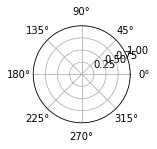

In [21]:
import seaborn as sns
import itertools as it

palette = it.cycle(sns.color_palette())
# dim2 = int(np.ceil(np.sqrt(len(randlist))))
# dim1=int(len(randlist)/dim2)

In_arr = Reconstructions[0:11]
V_arr = Phi

plt.figure(figsize=(8, 8))
for i in range(len(In_arr)):
    plt.subplot(3, 4, i+1, projection='polar')
    time_to_polar =np.linspace(0,2*np.pi, len(In_arr[i,:])) #time on the theta axis
    g = sns.lineplot(time_to_polar, In_arr[i,:], markers=True, color=next(palette))
    g.grid(b=True, which='major', color='w', linewidth=1.0)
    g.grid(b=True, which='minor', color='w', linewidth=0.5)
    g.set(xticklabels=[], yticklabels =[])
plt.suptitle('Inputs',fontsize=16, y=0.9)
plt.subplots_adjust(wspace=-0.1, hspace=-0.4)

plt.figure(figsize=(8, 8))
for i in range(len(Phi.T)):
    plt.subplot(1, 1, 1, projection='polar')
    time_to_polar =np.linspace(0,2*np.pi, len(V_arr[i,:])) #time on the theta axis
    g = sns.lineplot(time_to_polar, In_arr[i,:], markers=True, color=next(palette), mew=1.5)
    g.grid(b=True, which='major', color='w', linewidth=1.0)
    g.grid(b=True, which='minor', color='w', linewidth=0.5)
    g.set(xticklabels=[], yticklabels =[])
plt.suptitle('Dictionary',fontsize=16, y=0.95)


In [47]:
Beta_Sums

array([1.01835038, 0.43616859, 0.39403759, 0.38916511, 0.37002447,
       0.39147893, 0.38998445, 0.41126121, 0.41940829, 0.42681676])

In [48]:
beta

7

In [49]:
All_Sparse_Solutions = []


lam_values = np.arange(.3,1.5,.05)
print(len(lam_values))
lam_Reconstruction_Loss = []
for lam in lam_values:
    lam = lam #
    lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
    Total_Energies = []

    solver = conn.get_solver('DW_2000Q_5') 
    A = get_hardware_adjacency(solver)
    Unembedded_Solutions_Training= []
    Reconstruction_Error_Batch=[]
    t1 = time.time()
    New_Solutions = []
    Temp_Data_Patches=[]
    #Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
    #Q = np.squeeze(np.zeros((len(Phi.T),len(Phi.T))))
    #print(Q.shape)


    J0 =[]
    JC=[]
    Coefficients_sol =[]
    Coefficients_embsol=[]
    image_number = 0
    
    #number_of_images = len(Phi[1])
    for image in Indexing:
        temp = beta*data[image]
        h_vector = np.add(-np.dot(Phi.T,temp),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #print(h_vector)
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]
#         for i in range(0,len(Q)):
#             for j in range(i,len(Q)):
#                 if Q[i,j] < .1*Q.max():
#                     Q[i,j] = 0
#         #print(Q)
        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

        #embeddings = find_embedding(J_, A, verbose=1)
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)


        Temp_Data_Patches.append(temp)

            # solve embedded problem

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=1000)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])



                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
#             for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
#                 for j, emb in enumerate(embeddings):
#                     Coefficients_sol.append(sol[j])
#                     for k in emb:
#                         Coefficients_embsol.append(embsol[k])
        #print(Solutions)
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(0,len(Chains)):
            x = np.asarray(Solutions[j][0])
            #print(x)
            x = (x+1)/2
            #print(x)
            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        Reconstruction_Error_image = []
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
                Energy = sparse_loss(temp,Phi,New_Solutions[k],lam)
                Error = reconstruction_loss((1/float(beta))*temp,Phi,New_Solutions[k]*(1/float(beta)))
#                 print('e',Error)
#                 print('rec',LA.norm(temp-np.dot(Phi,New_Solutions[k])))
#                 print('norm',LA.norm(temp-np.dot(Phi,New_Solutions[k])))
                #print(Energy)
                All_Energies.append(Energy)
                Reconstruction_Error_image.append(Error)
        index_min = np.argmin(np.asarray(All_Energies))
        im = np.argmin(np.asarray(Reconstruction_Error_image))
        Reconstruction_Error_Batch.append(Reconstruction_Error_image[index_min])
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        print(New_Solutions[index_min])
        #print(LA.norm(temp-np.dot(Phi,New_Solutions[index_min]))**2-Reconstruction_Error_image[im])
        #print(New_Solutions[index_min])
    print(lam)
    print(sum(np.asarray(Reconstruction_Error_Batch))/len(Indexing))
    lam_Reconstruction_Loss.append(sum(np.asarray(Reconstruction_Error_Batch)))
    Sparse_Rep = np.asarray(Unembedded_Solutions_Training)
    Sparse_Rep = np.asmatrix(np.squeeze(np.asarray(Sparse_Rep)))
    All_Sparse_Solutions.append(Sparse_Rep)

24
[0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
[1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0]
[1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0
 1 1 

[0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0
 0 0 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.1999999999999997
0.4771182020513945
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

In [50]:
index_min_recon = np.argmin(np.asarray(lam_Reconstruction_Loss))
lam = lam_values[index_min_recon]

In [51]:
Indexing

[41894, 64480, 29422, 35009, 3336, 52267, 47689, 21493, 19854, 60071]

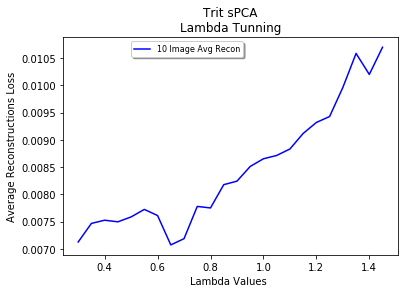

In [68]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(lam_values,np.asarray(lam_Reconstruction_Loss)/len(Indexing), 'k',color='blue',label='10 Image Avg Recon')

legend = ax.legend(loc='best', bbox_to_anchor=(0.55,1), shadow=True, fontsize='x-large',prop={'size': 8})
plt.xlabel('Lambda Values '),
plt.ylabel('Average Reconstructions Loss');
plt.title('Trit sPCA\nLambda Tunning')
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('C0')

plt.show()

In [53]:
lam

0.6499999999999999

In [57]:
#SGD Loop to update Dictionary
#Phi = Phi_New
mini_batch_size = 512
tol = 10**(-32)
max_iterations = 10000
eta_initial =.00001
eta_final = .000001#Learning Rate (Lower is better)
lam = lam 
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0
Previous_Gradient = 0
momentum_term = .2


Total_Loss=[]
Total_Energies = []

solver = conn.get_solver('DW_2000Q_5') 
A = get_hardware_adjacency(solver)
 #Helps see how sparse reconstructions are while learning
eta = eta_initial
#eta = eta

for iteration in range(max_iterations):
    
        
    #Random Draw from Data
    Indexing = random.sample(range(len(Data_Patches)), mini_batch_size)
    
    Neuron_Activation =[]
    Gradients =[]
  

    Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))

    lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
    h_vector = np.add(-np.dot(Phi.T,beta*Data_Patches[0,:].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
    h_vector = np.squeeze(np.asarray(h_vector))
    #Replace Diagonal of Q with corresponding h values    
    for i in range(0,len(Q)):
        Q[i,i]=h_vector[i]
    
#     for i in range(0,len(Q)):
#         for j in range(i,len(Q)):
#             if Q[i,j] < .1*Q.max():
#                 Q[i,j] = 0

    #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
    QDictionary ={}
    for i in range(0,len(Q)):
        for j in range(i,len(Q)):
                QDictionary[(i,j)] = Q[i,j]
                
    Embedding_Trials = 2
    Unembedded_Solutions=[]
    Embeddings =[]
    EmbeddingTime=[]
    J0 =[]
    JC=[]
    Coefficients_sol =[]
    Coefficients_embsol=[]

    for i in range(Embedding_Trials):

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        # embed the problem into solver graph
        try:
            embeddings = find_embedding(J_, A, verbose=1)
            (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)
            J0.append(j0)
            JC.append(jc)
            Embeddings.append(embeddings)
        except ValueError:
            time.sleep(30)
            print('No Embedding')
            
            try: 
                embeddings = find_embedding(J_, A, verbose=1)
                (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)
                Embeddings.append(embeddings)
                J0.append(j0)
                JC.append(jc)
            except ValueError:
                time.sleep(30)
                print('No Embedding')
                
                try: 
                    embeddings = find_embedding(J_, A, verbose=1)
                    (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)
                    Embeddings.append(embeddings)
                    J0.append(j0)
                    JC.append(jc)
                except ValueError:
                    time.sleep(30)
                    print('No Embedding')
                    embeddings = find_embedding(J_, A, verbose=1)
                    (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)
                    Embeddings.append(embeddings)

        Solutions = []
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

            # solve embedded problem

            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
            Answers.append(answer['energies'])

            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)

        New_Solutions=[]
        #Convert to {0,1}
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            for i in range(0,len(x)):
                if x[i] == -1:
                     x[i] = 0
            New_Solutions.append(x)
        Unembedded_Solutions.append(New_Solutions)
        if __name__ == "__main__":
            if len(sys.argv) == 1:
                embedding_example()
            else:
                print "Usage: "
 
    All_Energies = []
    for i in range(len(Unembedded_Solutions)):
        Energy_Chain = []
        for j in range(len(Chains)):
            Energy_Chain.append(sparse_loss(Data_Patches[0],Phi,Unembedded_Solutions[i][j],lam))
        index_min = np.argmin(np.asarray(Energy_Chain))
        All_Energies.append(Energy_Chain[index_min])
        
    index_min = np.argmin(np.asarray(All_Energies))
    embeddings = Embeddings[index_min]
    
    Unembedded_Solutions_Training= []
    Reconstruction_Error_Batch=[]
    t1 = time.time()
    New_Solutions = []
    Temp_Data_Patches=[]
    Non_Zero_Coefficients =[]


    J0 =[]
    JC=[]
    Coefficients_sol =[]
    Coefficients_embsol=[]
    image_number = 0
    Sparsity_Loss =[]
    Loss =[]
   
    for sample in Indexing:
        #print(LA.norm(Rand_Features[image]))
        temp = beta*Data_Patches[sample]
        #print(LA.norm(temp))
        h_vector = np.add(-np.dot(Phi.T,temp.T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #print(h_vector)
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]
        #print(Q)
        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    #print(i,j)
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

        #embeddings = find_embedding(J_, A, verbose=1)
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)


        Temp_Data_Patches.append(temp)

            # solve embedded problem

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=1000)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])



                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
#             for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
#                 for j, emb in enumerate(embeddings):
#                     Coefficients_sol.append(sol[j])
#                     for k in emb:
#                         Coefficients_embsol.append(embsol[k])
#         #print(Solutions)
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(0,len(Chains)):
            x = np.asarray(Solutions[j][0])
            #print(x)
            x = (x+1)/2
            #print(x)
            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        Reconstruction_Error_image = []
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
                Energy = sparse_loss((1/float(beta))*temp,Phi,(1/float(beta))*New_Solutions[k],(1/float(beta))*lam)
                Error = reconstruction_loss((1/float(beta))*temp,Phi,New_Solutions[k]*(1/float(beta)))
                #print(Energy)
                All_Energies.append(Energy)
                Reconstruction_Error_image.append(Error)
        index_min = np.argmin(np.asarray(All_Energies))
        im = np.argmin(np.asarray(Reconstruction_Error_image))
        Reconstruction_Error_Batch.append(Reconstruction_Error_image[index_min])
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        if image_number%10==0:
            print('Image Found', image_number)
        if image_number%10==0:
            print(New_Solutions[index_min])
            print(Reconstruction_Error_image[index_min])
        image_number+= 1
        #print('regular',sparse_loss(temp,Phi,New_Solutions[index_min].T,lam))
        #print('Transpose',sparse_loss(temp.T,Phi,New_Solutions[index_min].T,lam))
        
        Sparsity_Loss.append((sparse_loss((1/float(beta))*temp,Phi,(1/float(beta))*New_Solutions[index_min],(1/float(beta))*lam)))
        
        error = np.subtract((1/float(beta))*temp.T,np.squeeze(np.dot(Phi,(1/float(beta))*New_Solutions[index_min])))
        Loss.append(LA.norm(error))
        #print(error.shape)
        Delta_Phi = np.outer(error,New_Solutions[index_min])
        Delta_Phi =np.asarray(Delta_Phi)
        Gradients.append(Delta_Phi)
        Non_Zero_Index = np.nonzero(New_Solutions[index_min])
        Neuron_Activation.append(Non_Zero_Index)
        Non_Zero_Coefficients.append(np.count_nonzero(New_Solutions[index_min]))
    Neuron_Activation = np.asarray(Neuron_Activation)
    #print(Neuron_Activation)
    Gradients = np.asarray(Gradients)
    #print(Gradients.shape)
    
    Sparsity = sum(np.asarray(Non_Zero_Coefficients))/float(mini_batch_size)

    Delta_Phi=[]
    
    
    for col in range(Neurons):
        Number_of_Activations = 0
        Delta_Phi_Col_Sum =np.asmatrix(np.zeros(len(Phi)).T)
        for j in range(mini_batch_size):
            if col in Neuron_Activation[j][0]:
                #print(Neuron_Activation[j][1])
                #print('col',col)
                Number_of_Activations += 1
                Gradient_Columns = np.asmatrix(Gradients[j])
                #print(Delta_Phi_Col_Sum.shape)
                #print(Gradient_Columns[:,col].T.shape)
                Delta_Phi_Col_Sum += np.asarray(np.squeeze((Gradient_Columns[:,col].T)))
                
        if Number_of_Activations == 0: 
            Delta_Phi.append(Delta_Phi_Col_Sum)
                                             
        else:           
             Delta_Phi.append(Delta_Phi_Col_Sum/Number_of_Activations)                                     
        
        #print('Col, Number of activations, Col Change, Averaged Column Change',col, Number_of_Activations)#, Delta_Phi_Col_Sum,Delta_Phi_Col_Sum/Number_of_Activations)
                
    Delta_Phi = np.asarray(Delta_Phi)
    #Phi_New = Phi - (eta/mini_batch_size)*np.squeeze(Delta_Phi).T + momentum_term*Previous_Gradient
    Phi_New = Phi - (eta)*np.squeeze(Delta_Phi).T + momentum_term*Previous_Gradient #non division by mini batch size
    Previous_Gradient = np.squeeze(Delta_Phi).T


    for i in range(Neurons):
        if LA.norm(Phi_New[:,i])!=0:
#print((math.sqrt(Phi[:,i].T*Phi[:,i])))
            Phi_New[:,i]= Phi_New[:,i]/(LA.norm(Phi_New[:,i]))
#
    
    
    Loss = sum(np.asarray(Loss))/len(Indexing)
    Sparsity_Loss = sum(np.asarray(Sparsity_Loss))/len(Indexing)
    Total_Energies.append(Sparsity_Loss)
    Total_Loss.append(Loss)
    #normalize Updated Phi

    #if count%2==0:
    print(count,Total_Energies)
    print(Total_Loss,Sparsity_Loss,Sparsity)
    #print(plt.plot(range(iteration+1), Total_Energies ))
    #print('Energies,Epoc :', Total_Energies,count)
    elapsed1 = time.time() - t1
    #print(elapsed1)
    count += 1

    sio.savemat('Phi_New_Fashion_MiniBatch'+str(mini_batch_size)+'_sPCA_AFRL_32_Lambda_'+str(lam)+'_32_FinalLowNoise_Binned_Beta_'+str(beta)+'Tunned.mat', {'Phi_New':Phi_New})
    sio.savemat('TotalEnergies_Fashion_MiniBatch'+str(mini_batch_size)+'_sPCA_AFRL_32_Lambda_'+str(lam)+'_32_FinalLowNoise_Binned_Beta_'+str(beta)+'Tunned.mat', {'Total_Loss':Total_Loss})
    
    if LA.norm(Phi_New-Phi) > tol:
        print(LA.norm(Phi_New-Phi))
        print('eta',eta)
        Phi = Phi_New
        eta = eta_initial*(eta_final/float(eta_initial))**(iteration/float(max_iterations)) #exponentially decaying learing rate
    else:
        print('converged')
        
        break
        
        
        





component 0, try 0:
max overfill = 2, num max overfills = 207
max overfill = 2, num max overfills = 77
max overfill = 2, num max overfills = 77
max overfill = 2, num max overfills = 28
max overfill = 2, num max overfills = 10
max overfill = 2, num max overfills = 5
max overfill = 2, num max overfills = 5
max overfill = 2, num max overfills = 4
max overfill = 2, num max overfills = 4
max overfill = 2, num max overfills = 4
max overfill = 2, num max overfills = 4
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 3
shuffling vari

('Image Found', 290)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0]
0.34256924894579993
('Image Found', 300)
[0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
0.408836720543311
('Image Found', 310)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]
0.7511887954378023
('Image Found', 320)
[0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.28206582993129586
('Image Found', 330)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.22973738946552222
('Image Found', 340)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 

max overfill = 2, num max overfills = 16
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 15
component 0, try 4:
max overfill = 2, num max overfills = 143
max overfill = 2, num max overfills = 72
max overfill = 2, num max overfills = 68
max overfill = 2, num max overfills = 68
max overfill = 2, num max overfills = 68
max overfill = 2, num max overfills = 59
max overfill = 2, num max overfills = 15
max overfill = 2, num max overfills = 12
max overfill = 2, num max overfills = 5
max overfill = 2, num max overfills = 3
max overfill = 2, num max overfills = 2
max overfill = 2, num max overfills = 2
max overfill = 2, num max overfills = 2


('Image Found', 330)
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3148462602379109
('Image Found', 340)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
0.6025753181293163
('Image Found', 350)
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1]
0.29094251472750043
('Image Found', 360)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
0.3785076175901502
('Image Found', 370)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
0.18795727192989123
('Image Found', 380)
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

('Image Found', 120)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
0.7644612912203974
('Image Found', 130)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0]
0.26210765227141064
('Image Found', 140)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.26187463122085947
('Image Found', 150)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.9007930752230997
('Image Found', 160)
[1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
0.30773730289948276
('Image Found', 170)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0

Embedding found. Minimizing chains...
max chain size = 40, num max chains = 1, qubits used = 1525
max chain size = 39, num max chains = 2, qubits used = 1547
max chain size = 38, num max chains = 1, qubits used = 1495
max chain size = 37, num max chains = 1, qubits used = 1514
max chain size = 37, num max chains = 1, qubits used = 1514
Usage: 
('Image Found', 0)
[0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.46843043330910816
('Image Found', 10)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
0.33929531438062943
('Image Found', 20)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.7724677763388887
('Image Found', 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0

('Image Found', 460)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0]
0.42560910736326446
('Image Found', 470)
[0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.39674757803480143
('Image Found', 480)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1888037154187327
('Image Found', 490)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0]
0.36114754945296085
('Image Found', 500)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
0.3538188333647164
('Image Found', 510)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0

('Image Found', 260)
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
0.7802263584794606
('Image Found', 270)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]
0.6653631228986873
('Image Found', 280)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.355956768882374
('Image Found', 290)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
0.6762991027973271
('Image Found', 300)
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
0.2590678007814623
('Image Found', 310)
[0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

max overfill = 2, num max overfills = 39
max overfill = 2, num max overfills = 39
max overfill = 2, num max overfills = 39
max overfill = 2, num max overfills = 39
max overfill = 2, num max overfills = 39
component 0, try 3:
max overfill = 2, num max overfills = 187
max overfill = 2, num max overfills = 82
max overfill = 2, num max overfills = 16
max overfill = 2, num max overfills = 10
max overfill = 2, num max overfills = 5
max overfill = 2, num max overfills = 1
max overfill = 2, num max overfills = 1
max overfill = 2, num max overfills = 1
max overfill = 2, num max overfills = 1
max overfill = 1, num max overfills = 1679
max overfill = 1, num max overfills = 1679
Embedding found. Minimizing chains...
max chain size = 33, num max chains = 1, qubits used = 1679
max chain size = 33, num max chains = 1, qubits used = 1679
max chain size = 33, num max chains = 1, qubits used = 1636
max chain size = 33, num max chains = 1, qubits used = 1636
Usage: 
('Image Found', 0)
[0 0 1 0 0 0 0 1 1 

('Image Found', 430)
[0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
0.2766498560698339
('Image Found', 440)
[1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.36988106027828177
('Image Found', 450)
[0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.45697264669354043
('Image Found', 460)
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.4629882773403397
('Image Found', 470)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.37173723080940296
('Image Found', 480)
[1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0

Usage: 
component 0, try 0:
max overfill = 2, num max overfills = 120
max overfill = 2, num max overfills = 23
max overfill = 2, num max overfills = 2
max overfill = 1, num max overfills = 1632
max overfill = 1, num max overfills = 1632
Embedding found. Minimizing chains...
max chain size = 47, num max chains = 1, qubits used = 1632
max chain size = 47, num max chains = 1, qubits used = 1632
max chain size = 47, num max chains = 1, qubits used = 1632
max chain size = 44, num max chains = 1, qubits used = 1680
max chain size = 43, num max chains = 2, qubits used = 1624
max chain size = 43, num max chains = 2, qubits used = 1624
Usage: 
('Image Found', 0)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1]
0.13199802874672642
('Image Found', 10)
[0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3409249341180389
('Image Found', 2

('Image Found', 450)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.29552039350348097
('Image Found', 460)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.47983581685859644
('Image Found', 470)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.7993418586940306
('Image Found', 480)
[1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.32793386642597355
('Image Found', 490)
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
0.4835080886210838
('Image Found', 500)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1

('Image Found', 290)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.8140278689160804
('Image Found', 300)
[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0]
0.5861550329211015
('Image Found', 310)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.2847184768603964
('Image Found', 320)
[1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.22724058215223153
('Image Found', 330)
[1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3583250617621516
('Image Found', 340)
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

max chain size = 44, num max chains = 1, qubits used = 1713
Usage: 
('Image Found', 0)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
0.5686145880556146
('Image Found', 10)
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.43125800619655186
('Image Found', 20)
[1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.4645521883380041
('Image Found', 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3234410189522755
('Image Found', 40)
[0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.44412751107672915
('Image Found', 50)
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

('Image Found', 480)
[0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.1590391326630041
('Image Found', 490)
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
0.3742577884363605
('Image Found', 500)
[0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.33601671704550246
('Image Found', 510)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
0.191677226958856
(8, [0.9577969157835092, 0.964246865130066, 0.9544611755482924, 0.9520612170186913, 0.9778198069847598, 0.97622830079449, 0.9802094734147487, 0.9673905175217117, 0.9716972533459819])
([0.6484506187593287, 0.6550130741850961, 0.6506179934497645, 0.6423699407651942, 0.6263511681566156, 0.6145312873204074, 0.631972300

('Image Found', 300)
[0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.34446007139016793
('Image Found', 310)
[0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.2314996078234175
('Image Found', 320)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.802638894007864
('Image Found', 330)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.9300512800260834
('Image Found', 340)
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.4083396519881799
('Image Found', 350)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

RuntimeError: Bad server response from <https://cloud.dwavesys.com/sapi/problems/>: HTTP status code 503

In [15]:
Bad server response from <https://cloud.dwavesys.com/sapi/problems/>: missing key: id


[1.4133888347551218, 1.3063009711579834, 1.362340742720777]

In [60]:
sio.savemat('Phi_New_Fashion_MiniBatch'+str(mini_batch_size)+'_sPCA_AFRL_32_Lambda_'+str(lam)+'_32_Final.mat', {'Phi_New':Phi_New})
sio.savemat('TotalEnergies_Fashion_MiniBatch'+str(mini_batch_size)+'_sPCA_AFRL_32_Lambda_'+str(lam)+'_32_Final.mat', {'Total_Energies':Total_Energies})


In [58]:
#Get Linear Regression function
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys))/((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    
    b = np.mean(ys) - m*np.mean(xs)
    
    return m, b

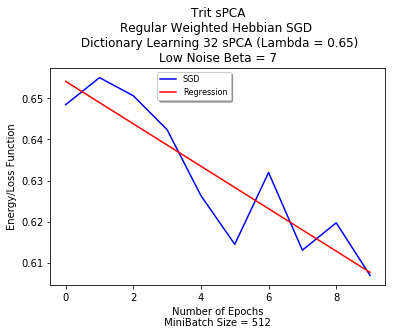

In [67]:
#Plot Learning Results
energy = np.asarray(Total_Loss)
#loss = np.asarray(Total_Loss)
low = min(energy)
xs = np.asarray(range(len(energy)))#np.array([1,2,3,4,5], dtype=np.float64)
ys = np.asarray(energy)# np.array([5,4,6,5,6], dtype=np.float64)

#Get linear regression best fit line
m, b = best_fit_slope_and_intercept(xs,ys)

regression_line = [(m*x)+b for x in xs]
a = range(len(energy))
b = energy
c = regression_line
d = [min(energy)]*len(energy)


# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, b, 'k',color='blue',label='SGD')
ax.plot(a, c, 'k', color='red',label='Regression')
#ax.plot(a, loss, 'k',color='green', label='loss')
#ax.axvline(x=19,linestyle='--', label ='Dropped Learning Rate')
# ax.axvline(x=220,linestyle='--', color='red',label ='Increase Learning Rate')
# ax.axvline(x=240,linestyle='--')
legend = ax.legend(loc='best', bbox_to_anchor=(0.55,1), shadow=True, fontsize='x-large',prop={'size': 8})
plt.xlabel('Number of Epochs\n MiniBatch Size = 512 '),
plt.ylabel('Energy/Loss Function');
plt.title('Trit sPCA\nRegular Weighted Hebbian SGD \n Dictionary Learning 32 sPCA (Lambda = '+str(np.round(lam,decimals=2))+')\nLow Noise Beta = '+str(beta)+'')
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('C0')

plt.show()

In [23]:
data

array([[ 0.28867516,  0.28867516,  0.28867516, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.28867516],
       [ 0.        , -0.28867516,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.4472136 , ..., -0.4472136 ,
        -0.4472136 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [61]:
#Get some reconstructions from trained Dicitionary 
#Best to split up in seperate notebooks to get results faster and then combine for full data set in sparse representation

Phi=Phi_New
Unembedded_Solutions_Training= []
t1 = time.time()
New_Solutions = []
Temp_Data_Patches=[]
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))


J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
image_number = 0

#lam = .1
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0


solver = conn.get_solver('DW_2000Q_5') 
A = get_hardware_adjacency(solver)
number_of_images = 5
#Can be used to get entire sparse rep of desired data set. 
#Only looking at 10 to get idea of learning
for image in range(number_of_images):

    #print(LA.norm(Rand_Features[image]))
    temp = data[image]
    #print(LA.norm(temp))
    h_vector = np.add(-np.dot(Phi.T,temp.T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
    h_vector = np.squeeze(np.asarray(h_vector))
    #print(h_vector)
    #Replace Diagonal of Q with corresponding h values    
    for i in range(0,len(Q)):
        Q[i,i]=h_vector[i]
    #print(Q)
    #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
    QDictionary ={}
    for i in range(0,len(Q)):
        for j in range(i,len(Q)):
                #print(i,j)
                QDictionary[(i,j)] = Q[i,j]
                #print(i,j,Q[i,j])

    (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        #[h_,J_, offsetarg]= qubo_to_ising[Q]

    #embeddings = find_embedding(J_, A, verbose=1)
    (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)


    Temp_Data_Patches.append(temp)

        # solve embedded problem

    Solutions =[]
    Answers=[]
    Chains = np.arange(- 3.5,-0.5,.5)
    for chain_strength in Chains:
            # set chain strength values
        jc = dict.fromkeys(jc, chain_strength)

        # create new J array concatenating j0 with jc
        emb_j = j0.copy()
        emb_j.update(jc)

            # solve embedded problem
        try:
            answer = solve_ising(solver, h0, emb_j, num_reads=20)# save results in an array
            Answers.append(answer['energies'])
        except RuntimeError:
            time.sleep(30)
            print('Runtime Error: Resubmitting Problem to D-Wave')
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                Answers.append(answer['energies'])

            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])
                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])

                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])



            # unembed and print result of the form:
            # solution [solution #]
            # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
        result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
        Solutions.append(result)
        for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
            for j, emb in enumerate(embeddings):
                Coefficients_sol.append(sol[j])
                for k in emb:
                    Coefficients_embsol.append(embsol[k])
    #print(Solutions)
    New_Solutions=[]
    #Convert to {0,1}
    for j in range(0,len(Chains)):
        x = np.asarray(Solutions[j][0])
        #print(x)
        x = (x+1)/2
        #print(x)
        New_Solutions.append(x)
    New_Solutions = np.asarray(New_Solutions)
    All_Energies =[]
    Reconstruction_Error_image = []
    for k in range(len(New_Solutions)): #Find for each chain strength
            #Energy function with 0 norm on lambda
            Energy = sparse_loss(temp,Phi,np.asmatrix(New_Solutions[k]).T,lam)
            Error = reconstruction_loss(temp,Phi,np.asmatrix(New_Solutions[k]).T)
            #print(Energy)
            All_Energies.append(Energy)
            Reconstruction_Error_image.append(Error)
    index_min = np.argmin(np.asarray(All_Energies))
    im = np.argmin(np.asarray(Reconstruction_Error_image))
    Reconstruction_Error_Batch.append(Reconstruction_Error_image[im])
    Unembedded_Solutions_Training.append(New_Solutions[index_min])
    if image_number%10==0:
        print('Image Found', image_number)
    if image_number%10==0:
        print(New_Solutions[index_min])
    image_number+= 1




Sparse_Rep = np.asarray(Unembedded_Solutions_Training)
Sparse_Rep = np.asmatrix(np.squeeze(np.asarray(Sparse_Rep)))
sio.savemat('Sparse_Rep_sPCA_AFRL_32_Trained_Lambda_.35_RSGD.mat', {'Sparse_Rep':Sparse_Rep})

('Image Found', 0)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [62]:
All_Reconstructions_Trained  = np.dot(Sparse_Rep,Phi.T)

In [63]:
All_Reconstructions_Trained.shape

(5L, 32L)

In [64]:
All_Reconstructions_Trained = All_Reconstructions_Trained.reshape(number_of_images,32)

In [98]:
Phi = data[Selected_Features,:].T
for i in range(Neurons):
    if LA.norm(Phi[:,i])!=0:
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))
        Phi[:,i]= Phi[:,i]/LA.norm(Phi[:,i])
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))


IndentationError: expected an indented block (<ipython-input-98-dcdf735d2bf0>, line 5)

In [15]:
#Get some reconstructions from Untrained Dicitionary 
#Phi = Phi_New_Binned
Unembedded_Solutions_Training= []
t1 = time.time()
New_Solutions = []
Temp_Data_Patches=[]
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))


J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
image_number = 0

#lam = .1
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0


solver = conn.get_solver('DW_2000Q_5') 
A = get_hardware_adjacency(solver)

#Can be used to get entire sparse rep of desired data set. 
#Only looking at 10 to get idea of learning
number_of_images = 10
for image in range(number_of_images):
    

    h_vector = np.add(-np.dot(Phi.T,data[image].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
    h_vector = np.squeeze(np.asarray(h_vector))
    #Replace Diagonal of Q with corresponding h values    
    for i in range(0,len(Q)):
        Q[i,i]=h_vector[i]

    #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
    QDictionary ={}
    for i in range(0,len(Q)):
        for j in range(i,len(Q)):
                QDictionary[(i,j)] = Q[i,j]
                #print(i,j,Q[i,j])

    (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        #[h_,J_, offsetarg]= qubo_to_ising[Q]

#         embeddings = find_embedding(J_, A, verbose=1)
    (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)

    Solutions =[]
    Answers=[]

    Temp_Data_Patches.append(data[image].T)

        # solve embedded problem

    Solutions =[]
    Answers=[]
    for chain_strength in Chains:
            # set chain strength values
        jc = dict.fromkeys(jc, chain_strength)

        # create new J array concatenating j0 with jc
        emb_j = j0.copy()
        emb_j.update(jc)

            # solve embedded problem
        try:
            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
            Answers.append(answer['energies'])
        except RuntimeError:
            time.sleep(30)
            print('Runtime Error: Resubmitting Problem to D-Wave')
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                Answers.append(answer['energies'])

            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])
                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])

                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])



            # unembed and print result of the form:
            # solution [solution #]
            # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
        result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
        Solutions.append(result)
        #Solutions.append(result['energies']) DOESNT HAVE energies AS AN OUTPUT

        #print(result)
        #print "result for chain strength = ", chain_strength
        for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
            #print "solution", i
            #save solution coefficients
            for j, emb in enumerate(embeddings):
                Coefficients_sol.append(sol[j])
                #print "var %d: %d (" % (j, sol[j]),
                for k in emb:
                    Coefficients_embsol.append(embsol[k])
                    #print "%d:%d" % (k, embsol[k]),
                #print ")"
        #print "Solutions", Solutions
    New_Solutions=[]
    #Convert to {0,1}
    for j in range(len(Chains)):
        x = np.asarray(Solutions[j][0])
        x = (x+1)/2
#             for i in range(0,Phi.shape[1]):
#                 if x[i] == -1:
#                      x[i] = 0
        New_Solutions.append(x)
    New_Solutions = np.asarray(New_Solutions)
    #Normalize Solutions
    All_Energies =[]
    for k in range(len(New_Solutions)): #Find for each chain strength
            New_Solutions[k]=New_Solutions[k]/LA.norm(New_Solutions[k])
            #Energy function with 0 norm on lambda
            Energy = sparse_loss(data[image],Phi,np.asmatrix(New_Solutions[k]).T,lam)
            #print(Energy)
            All_Energies.append(Energy)
    index_min = np.argmin(np.asarray(All_Energies))
    Unembedded_Solutions_Training.append(New_Solutions[index_min])
    if image_number%10==0:
        print('Image Found', image_number)
    if image_number%10==0:
        print(New_Solutions[index_min])
    image_number+= 1




Sparse_Rep_Untrained  = np.asarray(Unembedded_Solutions_Training)
Sparse_Rep_Untrained= np.asmatrix(np.squeeze(np.asarray(Sparse_Rep_Untrained)))
#sio.savemat('Sparse_Rep_sPCA_AFRL_32_Untrained.mat', {'Sparse_Rep':Sparse_Rep})

SyntaxError: invalid syntax (<ipython-input-15-53b6418265fe>, line 29)

In [28]:
lam

0.47499999999999987

In [ ]:
#Get some reconstructions from Untrained Dicitionary 
#Phi = Phi_New_Binned
Unembedded_Solutions_Training= []
t1 = time.time()
New_Solutions = []
Temp_Data_Patches=[]
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))


J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
image_number = 0

#lam = .1
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0


solver = conn.get_solver('DW_2000Q_5') 
A = get_hardware_adjacency(solver)

#Can be used to get entire sparse rep of desired data set. 
#Only looking at 10 to get idea of learning
number_of_images = 5
Indexing = random.sample(range(len(data)), number_of_images)
beta_vec = [ 1, 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]
beta_vec = [1,2,3,4,5,6,7,8]
Reconstruction_Error_All=[]
for image in Indexing:
    
    Reconstruction_Error_Image =[]
    for beta in beta_vec:
        print(image,beta)
        temp = beta*data[image]
        h_vector = np.add(-np.dot(Phi.T,temp.T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]

        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

    #         embeddings = find_embedding(J_, A, verbose=1)
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)

        Solutions =[]
        Answers=[]

        Temp_Data_Patches.append(data[image].T)

            # solve embedded problem

        Solutions =[]
        Answers=[]
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=1000)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])



                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
 
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            x = (x+1)/2

            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        Reconstruction_Error_image=[]
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
                Energy = sparse_loss(temp,Phi,New_Solutions[k],lam)
                Error = reconstruction_loss(temp,Phi,New_Solutions[k])
                Reconstruction_Error_image.append(Error)
                All_Energies.append(Energy)
        index_min = np.argmin(np.asarray(All_Energies))
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        im = np.argmin(np.asarray(Reconstruction_Error_image))
        Reconstruction_Error_Image.append(Reconstruction_Error_image[im])
        if image_number%10==0:
            print('Image Found', image_number)
        #if image_number%10==0:
            print(New_Solutions[index_min])
        image_number+= 1
    Reconstruction_Error_All.append(Reconstruction_Error_Image)



Sparse_Rep_Untrained  = np.asarray(Unembedded_Solutions_Training)


(58682, 1)
('Image Found', 0)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(58682, 2)
(58682, 3)
(58682, 4)
(58682, 5)
(58682, 6)
(58682, 7)
(58682, 8)
(22665, 1)
(22665, 2)
(22665, 3)
('Image Found', 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(22665, 4)
(22665, 5)
(22665, 6)
(22665, 7)
(22665, 8)
(19793, 1)
(19793, 2)
(19793, 3)
(19793, 4)
(19793, 5)


In [70]:
beta_vec = [1, 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [81]:
Sparse_Rep_Untrained  = np.asarray(Unembedded_Solutions_Training)


In [82]:
#Load sPCA Dictionary from found sPCA components
mat = sio.loadmat('sPCA_Phi.mat')
sPCA_Phi = mat['sPCA_Phi']

In [83]:
data = data.reshape(70000,32)

In [94]:
sPCA_Reconstruction = np.dot(data[Indexing],sPCA_Phi)
sPCA_Reconstruction.shape

(5L, 784L)

In [95]:

for i in range(len(Reconstruction_Error_All)):
    print('image',i,'recon error',Reconstruction_Error_All[i])

('image', 0, 'recon error', [0.8954468835453787, 1.645862343029165, 4.4617081298831325, 6.347789858024729, 7.47711616691658, 12.998550600405343, 25.07277306622997, 44.21433267188044, 72.45481097162573, 107.12869644249146, 148.7553027002367])
('image', 1, 'recon error', [0.7400629310508924, 3.1564224965886565, 6.027561359500759, 10.32815081878234, 13.892725332851086, 19.07298032223162, 27.334498457972035, 39.96641789388095, 60.598337329789864, 92.52052837637771, 128.38927106237037])
('image', 2, 'recon error', [1.0, 2.8400594103409693, 7.518097095545096, 9.771506127795773, 21.167062923973766, 40.81079440902044, 63.1091110935016, 92.00072662446547, 127.95120713693389, 172.9932489174345, 224.21293541905698])
('image', 3, 'recon error', [0.9988754249973535, 2.3476829546819844, 4.977324867676581, 10.950203041321954, 20.086694716436178, 40.12831505079069, 65.28895447338513, 95.92107503059714, 136.1645397856731, 180.49572000810105, 237.95743131549867])
('image', 4, 'recon error', [0.496444189

In [96]:
#Vectorized Build
All_Reconstructions_UnTrained  = np.dot(Sparse_Rep_Untrained,Phi.T)
All_Reconstructions_UnTrained_Final = np.dot(All_Reconstructions_UnTrained,sPCA_Phi)
All_Reconstructions_UnTrained_Final = All_Reconstructions_UnTrained_Final.reshape(number_of_images,len(beta_vec),28*28)

In [98]:
beta_vec

[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

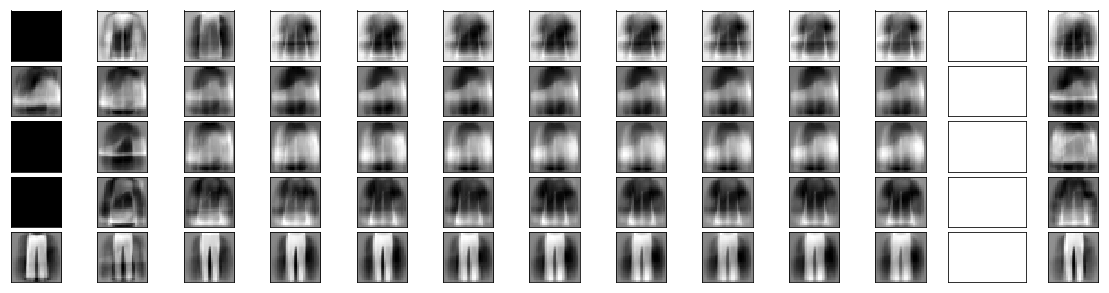

In [97]:
# Plot the results
fig, ax = plt.subplots(number_of_images, len(beta_vec)+2, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(number_of_images):
    for j in range(len(beta_vec)):
        ax[i, j].imshow(All_Reconstructions_UnTrained_Final[i][j].reshape(28,28), cmap='binary_r')
    ax[i,len(beta_vec)+1].imshow(sPCA_Reconstruction[i].reshape(28,28), cmap='binary_r')
    
# for k in range(len(beta_vec)):
#     ax[number_of_images-1].set_xlabel(str(beta_vec[k]),rotation=90,labelpad=100)
# ax[number_of_images, len(beta_vec)+1].set_xlabel('original',rotation=90,labelpad=100)

In [ ]:
# Plot the results
fig, ax = plt.subplots(1, len(sPCA_Reconstruction), figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(len(sPCA_Reconstruction)):
    ax[i].imshow(sPCA_Reconstruction[i].reshape(28,28), cmap='binary_r')


In [50]:
sPCA_Reconstruction[i].shape
len(sPCA_Reconstruction)

4

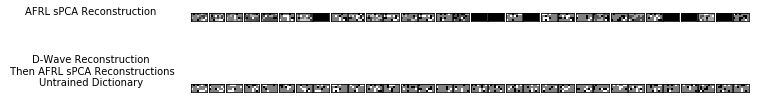

In [127]:
# Plot the results
fig, ax = plt.subplots(2, len(All_Reconstructions_UnTrained), figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(len(All_Reconstructions_UnTrained_Final)):
    ax[0, i].imshow(All_Reconstructions_UnTrained[i].reshape(4,8), cmap='binary_r')
    ax[1, i].imshow(Phi[:,i].reshape(4,8), cmap='binary_r')
    #print(immatrix[i].reshape(32,32).shape)
    #ax[2, i].imshow(All_Reconstructions_Trained_Final[i].reshape(28,28), cmap='binary_r')
    #print(projected[i].reshape(32,32).shape)
    
ax[0, 0].set_ylabel('AFRL sPCA Reconstruction',rotation=0,labelpad=100)
ax[1, 0].set_ylabel('D-Wave Reconstruction\n Then AFRL sPCA Reconstructions\nUntrained Dictionary',rotation=0,labelpad=100);

In [88]:
#Load sPCA Dictionary from found sPCA components
mat = sio.loadmat('sPCA_Phi.mat')
sPCA_Phi = mat['sPCA_Phi']

In [89]:
data = data.reshape(70000,32)

In [125]:
#Reconstruct back to original data dimensions
sPCA_Reconstruction = np.dot(Phi.T,sPCA_Phi)
All_Reconstructions_UnTrained_Final = np.dot(All_Reconstructions_UnTrained,sPCA_Phi)
#All_Reconstructions_Trained_Final = np.dot(All_Reconstructions_Trained,sPCA_Phi)

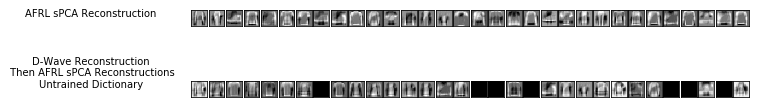

In [211]:
# Plot the results
fig, ax = plt.subplots(2, len(All_Reconstructions_UnTrained_Final), figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(len(All_Reconstructions_UnTrained_Final)):
    ax[0, i].imshow(sPCA_Reconstruction[i].reshape(28,28), cmap='binary_r')
    ax[1, i].imshow(All_Reconstructions_UnTrained_Final[i].reshape(28,28), cmap='binary_r')
    #print(immatrix[i].reshape(32,32).shape)
    #ax[2, i].imshow(All_Reconstructions_Trained_Final[i].reshape(28,28), cmap='binary_r')
    #print(projected[i].reshape(32,32).shape)
    
ax[0, 0].set_ylabel('AFRL sPCA Reconstruction',rotation=0,labelpad=100)
ax[1, 0].set_ylabel('D-Wave Reconstruction\n Then AFRL sPCA Reconstructions\nUntrained Dictionary',rotation=0,labelpad=100);
#ax[2, 0].set_ylabel('D-Wave Reconstruction\n Then AFRL sPCA Reconstructions\nTrained Dictionary',rotation=0,labelpad=100);

In [43]:
LA.norm(sPCA_Reconstruction[0:len(All_Reconstructions_Trained_Final)]-All_Reconstructions_UnTrained_Final)

3.2399269669025212

In [44]:
LA.norm(sPCA_Reconstruction[0:len(All_Reconstructions_Trained_Final)]-All_Reconstructions_Trained_Final)

3.5366914384185346

In [42]:
All_Reconstructions_Trained_Final[0]

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -2.14451817e-03, -1.99853193e-02,
         -5.19144187e-02, -9.71906724e-02, -1.20196999e-01,
         -9.96423032e-02, -7.78834731e-02, -7.18581100e-02,
         -8.97025090e-02, -1.17341728e-01, -1.13045900e-01,
         -4.57679941e-02, -3.04307539e-02, -9.69439565e-03,
         -2.33467174e-04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.86316958e-03, -3.75209764e-02, -9.79302156e-02,
         -1.49972104e-01, -1.68577192e-01, -1.22797887e-01,
         -1.16442138e-01, -1.27796326e-01, -1.47213620e-01,
         -1.45744953e-01, -1.39843915e-01, -1.34215721e-01,
         -1.36198915e-01, -1.10863886e-01, -1.53399962e-01,
         -1.32538462e-01, -6.13275371e-0

In [43]:
All_Reconstructions_UnTrained_Final[0]

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -1.01533245e-03, -8.65564362e-03,
         -1.79521341e-02,  6.68941393e-02,  1.27026729e-01,
          1.64867109e-01,  1.70033157e-01,  1.64093372e-01,
          1.73891827e-01,  1.38912336e-01,  7.23925335e-02,
          1.12292997e-02, -1.26670817e-02, -3.81725695e-03,
          2.47885339e-04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.35558142e-03, -4.23209451e-03, -8.90048804e-03,
         -3.58263053e-02, -5.88996176e-02,  3.07182384e-02,
          1.01356350e-01,  1.68176868e-01,  1.89205964e-01,
          1.93241893e-01,  1.74373578e-01,  1.50242922e-01,
          2.73980777e-02, -4.71519758e-02, -4.59121141e-02,
         -5.98777785e-03,  9.06107853e-0